In [1]:
%matplotlib inline
import os
import sys
sys.path.append('..')
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu
import glob
import zipfile
# flag to decide if run everything or just visualize results
run_all_flag = True

In [2]:
import freyberg_setup
working_dir = freyberg_setup.WORKING_DIR_KR
pst_name = freyberg_setup.PST_NAME_KR
freyberg_setup.setup_pest_kr()


if not run_all_flag:
    shutil.copy2('sweep.zip',os.path.join(working_dir,'sweep.zip'))
    with zipfile.ZipFile(os.path.join(working_dir,'sweep.zip')) as inzip:
        inzip.extractall(working_dir)


changing model workspace...
   freyberg_kr
FloPy is using the following  executable to run the model: /Users/mnfienen/Documents/GIT/GW1876/activities/freyberg_k_and_r_response_surface/freyberg_kr/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.4 4/01/2018                         
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/10/10 20:36:36

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:

/Users/mnfienen/Documents/GIT/pyemu/pyemu/utils/gw_utils.py:1607: PyemuWarning: Flow out (flout) of grouped segments will be aggregated... 
  warnings.warn("Flow out (flout) of grouped segments will be aggregated... ", PyemuWarning)


writing 'sfr_obs.config' to sfr_obs.config
                                    obsnme     obsval  weight    obgnme
c001fr05c04_19791231  c001fr05c04_19791231  29.135645     0.0  forehead
c001fr16c17_19791231  c001fr16c17_19791231  21.775225     0.0  forehead
noptmax: 0
noptmax: 8


## First read in the PST file and find what are the starting values for K and R

In [3]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
inpst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
hk,hk,log,factor,5.00,0.500,50.00,hk,1.0,0.0,1,NaN
porosity,porosity,log,factor,0.01,0.005,0.02,porosity,1.0,0.0,1,NaN
rch_0,rch_0,fixed,factor,1.00,0.500,2.00,rch,1.0,0.0,1,NaN
rch_1,rch_1,fixed,factor,1.00,0.250,3.00,rch,1.0,0.0,1,NaN


In [4]:
inpst.parameter_data.loc['rch_1','partrans']= 'fixed'
inpst.parameter_data.loc['rch_0','partrans']= 'log'
inpst.parameter_data.loc['rch_0','parval1']= 8.0E-1
inpst.parameter_data.loc['hk', 'parval1'] = 12.0
inpst.observation_data.loc[inpst.observation_data.obgnme=='calflux','weight']=0.0
inpst.control_data.noptmax=0
inpst.write(os.path.join(working_dir,pst_name))

noptmax: 0


In [5]:
os.chdir(working_dir)
pyemu.os_utils.run('pestpp {0}'.format(pst_name))
os.chdir('..')

In [6]:
inpst.phi_components

{'calflux': 0.0,
 'calhead': 2137.6569795865717,
 'flaqx': 0.0,
 'flout': 0.0,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_storage': 0.0,
 'flx_stream_': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'forecast': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_storage': 0.0,
 'vol_stream_': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

## We can import a function to explore a range of K and R values to make a response surface

In [7]:
import response_surface as resurf

## First we should write out the control file with new bounds to bracket where values will be explored

## `rch_0` already spans the bounds we want, but `hk` is too wide

In [8]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
par = inpst.parameter_data
inpst.parameter_data.loc['hk', 'parval1'] = 12.0
par.loc['hk', 'parlbnd'] = 3
par.loc['hk', 'parubnd'] = 12

inpst.write(os.path.join(working_dir,pst_name))

noptmax: 0


In [9]:
inpst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
hk,hk,log,factor,12.00,3.000,12.00,hk,1.0,0.0,1,NaN
porosity,porosity,log,factor,0.01,0.005,0.02,porosity,1.0,0.0,1,NaN
rch_0,rch_0,log,factor,0.80,0.500,2.00,rch,1.0,0.0,1,NaN
rch_1,rch_1,fixed,factor,1.00,0.250,3.00,rch,1.0,0.0,1,NaN


In [10]:
inpst.observation_data.loc[inpst.nnz_obs_names]

,obsnme,obsval,weight,obgnme,extra
obsnme,,,,,
c001cr03c10_19700102,c001cr03c10_19700102,26.262615,5.0,calhead,NaN
c001cr03c16_19700102,c001cr03c16_19700102,23.463532,5.0,calhead,NaN
c001cr04c09_19700102,c001cr04c09_19700102,28.126832,5.0,calhead,NaN
c001cr10c02_19700102,c001cr10c02_19700102,30.430534,5.0,calhead,NaN
c001cr14c11_19700102,c001cr14c11_19700102,25.442033,5.0,calhead,NaN
c001cr16c17_19700102,c001cr16c17_19700102,20.064206,5.0,calhead,NaN
c001cr22c11_19700102,c001cr22c11_19700102,24.333130,5.0,calhead,NaN
c001cr23c16_19700102,c001cr23c16_19700102,19.950425,5.0,calhead,NaN
c001cr25c05_19700102,c001cr25c05_19700102,24.844271,5.0,calhead,NaN


## Run the `run_respsurf` function to calculate the response surface

In [11]:
if run_all_flag:
    resurf.run_respsurf(par_names=['hk','rch_0'], pstfile=pst_name)

noptmax: 0


/Users/mnfienen/Documents/GIT/pyemu/pyemu/utils/helpers.py:1064: PyemuWarning: start_slaves has moved to pyemu.os_utils
  warnings.warn("start_slaves has moved to pyemu.os_utils",PyemuWarning)


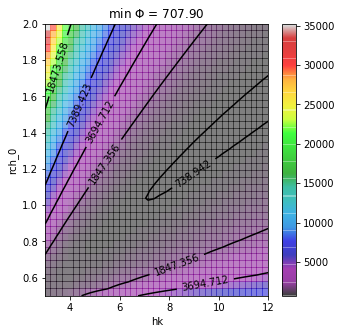

In [12]:
resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name);

In [13]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
inpst.parameter_data.loc['hk', 'parval1'] = 12.0
inpst.parameter_data.loc['rch_0', 'parval1'] = 0.8
inpst.parameter_data.loc['rch_0', 'partrans'] = 'log'
inpst.control_data.noptmax =  -1
inpst.write(os.path.join(working_dir,pst_name))

noptmax: -1


In [14]:
os.chdir(working_dir)
pyemu.os_utils.run('pestpp {0}'.format(pst_name))
os.chdir('..')

### Now let's run PEST++ and see what we get for an estimate of the parameters
 * set NOPTMAX=-1
 * run PEST++

In [15]:
pars = pd.read_csv(os.path.join(working_dir,pst_name.replace('.pst','.ipar')))
pars

,iteration,hk,porosity,rch_0,rch_1
0,0,12,0.01,0.8,1


In [16]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace('.pst','.jcb')))
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,hk,porosity,rch_0
hk,8472.050876,0.0,-11707.114827
porosity,0.000000,0.0,0.000000
rch_0,-11707.114827,0.0,16700.913065


In [17]:
R = covar.to_pearson()
R.df()

/Users/mnfienen/Documents/GIT/pyemu/pyemu/mat/mat_handler.py:2718: RuntimeWarning: invalid value encountered in double_scalars
  pearson[i,j+i+1] = df.loc[iname,jname] / (std_dict[iname] * std_dict[jname])


,hk,porosity,rch_0
hk,1.000000,NaN,-0.984205
porosity,NaN,1.0,NaN
rch_0,-0.984205,NaN,1.000000


# What if we also have a calibration flux observation?

We can set this up by simply assigning non-zero weight to the observation in the group called `calflux`

We'll read in the PST file, change just that one value and write out a new PST file.

In [18]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))

In [19]:
inpst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
hk,hk,log,factor,12.00,3.000,12.00,hk,1.0,0.0,1,NaN
porosity,porosity,log,factor,0.01,0.005,0.02,porosity,1.0,0.0,1,NaN
rch_0,rch_0,log,factor,0.80,0.500,2.00,rch,1.0,0.0,1,NaN
rch_1,rch_1,fixed,factor,1.00,0.250,3.00,rch,1.0,0.0,1,NaN


In [20]:
inpst.parameter_data.loc['rch_1','partrans']= 'fixed'
###
# Let's fix porosity to avoid getting NaN in our correlation matrices

inpst.parameter_data.loc['porosity','partrans']= 'fixed'

inpst.parameter_data.loc['hk','parval1']= 12.0

inpst.observation_data.loc[inpst.observation_data.obgnme=='calflux','weight']=10
inpst.control_data.noptmax=0
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r1.pst')))

noptmax: 0


In [21]:
inpst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
hk,hk,log,factor,12.00,3.000,12.00,hk,1.0,0.0,1,NaN
porosity,porosity,fixed,factor,0.01,0.005,0.02,porosity,1.0,0.0,1,NaN
rch_0,rch_0,log,factor,0.80,0.500,2.00,rch,1.0,0.0,1,NaN
rch_1,rch_1,fixed,factor,1.00,0.250,3.00,rch,1.0,0.0,1,NaN


In [22]:
os.chdir(working_dir)
pyemu.os_utils.run('pestpp {0}'.format(pst_name.replace('.pst','.r1.pst')))
os.chdir('..')

In [23]:
inpst.phi_components

{'calflux': 395293924.0,
 'calhead': 2137.6569795865717,
 'flaqx': 0.0,
 'flout': 0.0,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_storage': 0.0,
 'flx_stream_': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'forecast': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_storage': 0.0,
 'vol_stream_': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

In [24]:
if run_all_flag:
    resurf.run_respsurf(par_names=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r1.pst'))

noptmax: 0


/Users/mnfienen/Documents/GIT/pyemu/pyemu/utils/helpers.py:1064: PyemuWarning: start_slaves has moved to pyemu.os_utils
  warnings.warn("start_slaves has moved to pyemu.os_utils",PyemuWarning)


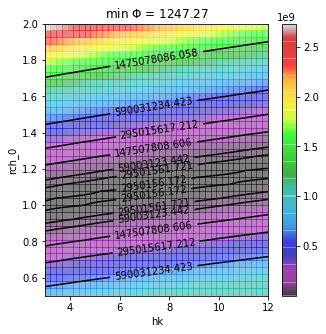

In [25]:
resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r1.pst'));

In [26]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name.replace('.pst','.r1.pst')))
inpst.parameter_data.loc['hk', 'parval1'] = 12
inpst.parameter_data.loc['rch_0', 'parval1'] = 0.8

inpst.control_data.noptmax =  -1
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r1.pst')))

noptmax: -1


In [27]:
os.chdir(working_dir)
pyemu.os_utils.run('pestpp {0}'.format(pst_name.replace('.pst','.r1.pst')))
os.chdir('..')

### We can look at the correlation again

In [28]:
pars = pd.read_csv(os.path.join(working_dir,pst_name.replace('.pst','.r1.ipar')))
pars

,iteration,hk,porosity,rch_0,rch_1
0,0,12,0.01,0.8,1


In [29]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace('.pst','.r1.jcb')))
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,hk,rch_0
hk,4.638033e+08,-2.023344e+09
rch_0,-2.023344e+09,8.826921e+09


In [30]:
R = covar.to_pearson()
R.df()

,hk,rch_0
hk,1.000000,-0.999996
rch_0,-0.999996,1.000000


In [31]:
sc.jco.to_dataframe().loc[inpst.nnz_obs_names]

,hk,rch_0
c001cr03c10_19700102,-6.570923,9.640966
c001cr03c16_19700102,-3.647503,6.409655
c001cr04c09_19700102,-7.129388,10.242119
c001cr10c02_19700102,-11.540738,13.890529
c001cr14c11_19700102,-2.374132,5.650931
c001cr16c17_19700102,-1.250647,3.293986
c001cr22c11_19700102,-2.147775,4.144075
c001cr23c16_19700102,-0.567642,1.816702
c001cr25c05_19700102,-7.017958,9.124556
c001cr27c07_19700102,-5.038859,7.283579


## OK - that was bonkers. Maybe a little less weight?

In [32]:
inpst.parameter_data.loc['rch_1','partrans']= 'fixed'

inpst.observation_data.loc[inpst.observation_data.obgnme=='calflux','weight']=0.001
inpst.control_data.noptmax=0
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r2.pst')))

noptmax: 0


In [33]:
inpst.parameter_data


,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
hk,hk,log,factor,12.00,3.000,12.00,hk,1.0,0.0,1,NaN
porosity,porosity,fixed,factor,0.01,0.005,0.02,porosity,1.0,0.0,1,NaN
rch_0,rch_0,log,factor,0.80,0.500,2.00,rch,1.0,0.0,1,NaN
rch_1,rch_1,fixed,factor,1.00,0.250,3.00,rch,1.0,0.0,1,NaN


In [34]:
os.chdir(working_dir)
pyemu.os_utils.run('pestpp {0}'.format(pst_name.replace('.pst','.r2.pst')))
os.chdir('..')

In [35]:
inpst.phi_components

{'calflux': 3.952939240000001,
 'calhead': 2137.6569795865717,
 'flaqx': 0.0,
 'flout': 0.0,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_storage': 0.0,
 'flx_stream_': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'forecast': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_storage': 0.0,
 'vol_stream_': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

In [36]:
if run_all_flag:
    resurf.run_respsurf(par_names=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r2.pst'))

noptmax: 0


/Users/mnfienen/Documents/GIT/pyemu/pyemu/utils/helpers.py:1064: PyemuWarning: start_slaves has moved to pyemu.os_utils
  warnings.warn("start_slaves has moved to pyemu.os_utils",PyemuWarning)


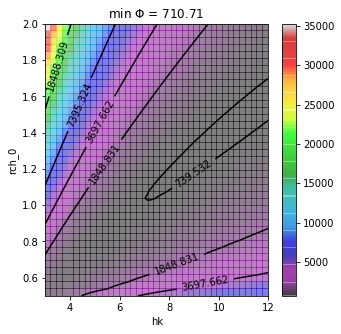

In [37]:
resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r2.pst'));

In [38]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name.replace('.pst','.r2.pst')))
inpst.parameter_data.loc['hk', 'parval1'] = 12
inpst.parameter_data.loc['rch_0', 'parval1'] = 0.8

inpst.control_data.noptmax =  -1
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r2.pst')))

noptmax: -1


In [39]:
os.chdir(working_dir)
pyemu.os_utils.run('pestpp {0}'.format(pst_name.replace('.pst','.r2.pst')))
os.chdir('..')

## Let's check out correlation again

In [40]:
pars = pd.read_csv(os.path.join(working_dir,pst_name.replace('.pst','.r2.ipar')))
pars

,iteration,hk,porosity,rch_0,rch_1
0,0,12,0.01,0.8,1


In [41]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace('.pst','.r2.jcb')))
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,hk,rch_0
hk,8476.688824,-11727.348148
rch_0,-11727.348148,16789.182104


In [42]:
R = covar.to_pearson()
R.df()

,hk,rch_0
hk,1.000000,-0.983042
rch_0,-0.983042,1.000000


## Can we find a happy medium? Perhaps if we balance the components of the objective function

In [43]:
inpst.parameter_data.loc['rch_1','partrans']= 'fixed'
inpst.observation_data.loc[inpst.observation_data.obgnme=='calflux','weight']=0.05
inpst.control_data.noptmax=0
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r3.pst')))

noptmax: 0


In [44]:
os.chdir(working_dir)
pyemu.os_utils.run('pestpp {0}'.format(pst_name.replace('.pst','.r3.pst')))
os.chdir('..')

In [45]:
inpst.phi_components

{'calflux': 9882.3481000000029,
 'calhead': 2137.6569795865717,
 'flaqx': 0.0,
 'flout': 0.0,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_storage': 0.0,
 'flx_stream_': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'forecast': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_storage': 0.0,
 'vol_stream_': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

In [46]:
if run_all_flag:
    resurf.run_respsurf(par_names=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r3.pst'))

noptmax: 0


/Users/mnfienen/Documents/GIT/pyemu/pyemu/utils/helpers.py:1064: PyemuWarning: start_slaves has moved to pyemu.os_utils
  warnings.warn("start_slaves has moved to pyemu.os_utils",PyemuWarning)


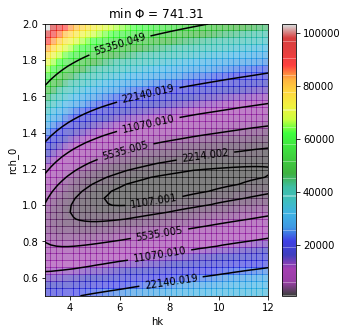

In [47]:
resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name.replace('.pst','.r3.pst'));

In [48]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name.replace('.pst','.r3.pst')))
inpst.parameter_data.loc['hk', 'parval1'] = 7
inpst.parameter_data.loc['rch_0', 'parval1'] = 1.0
inpst.parameter_data.loc['rch_0', 'parlbnd'] = 0.6


inpst.control_data.noptmax =  -1
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.r3.pst')))

noptmax: -1


In [49]:
os.chdir(working_dir)
pyemu.os_utils.run('pestpp {0}'.format(pst_name.replace('.pst','.r3.pst')))
os.chdir('..')

In [50]:
pars = pd.read_csv(os.path.join(working_dir,pst_name.replace('.pst','.r3.ipar')))
pars

,iteration,hk,porosity,rch_0,rch_1
0,0,7,0.01,1,1


In [51]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace('.pst','.r3.jcb')))
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df()

,hk,rch_0
hk,24981.358081,-72633.417063
rch_0,-72633.417063,395017.620100


In [52]:
R = covar.to_pearson()
R.df()

,hk,rch_0
hk,1.000000,-0.731173
rch_0,-0.731173,1.000000
